**NOTE THAT THIS NOTEBOOK WAS RUN IN GOOGLE COLAB AS SUCH CERTAIN IMPORT STATEMENTS MAY DIFFER**

In [0]:
import tensorflow as tf
from tensorflow.keras import Model
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 

from keras import backend as K
from sklearn.metrics import f1_score
import math

from keras.optimizers import adam
from keras.optimizers import SGD

from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import pandas as pd

train_path=os.path.abspath(os.path.join(os.path.dirname("__file__"), '..', '/content/drive/My Drive/datasets/train.csv'))
training_df = pd.read_csv(train_path, index_col="tripid")


In [0]:
def dist_from_coordinates(lat1, lon1, lat2, lon2):
  R = 6371  # Earth radius in km

  #conversion to radians
  d_lat = np.radians(lat2-lat1)
  d_lon = np.radians(lon2-lon1)

  r_lat1 = np.radians(lat1)
  r_lat2 = np.radians(lat2)

  #haversine formula
  a = np.sin(d_lat/2.) **2 + np.cos(r_lat1) * np.cos(r_lat2) * np.sin(d_lon/2.)**2

  haversine = 2 * R * np.arcsin(np.sqrt(a))

  return haversine

In [0]:
training_df = training_df.fillna(0)

In [0]:
training_df['pickup_time'] = pd.to_datetime(training_df['pickup_time'], format="%m/%d/%Y %H:%M")
training_df['drop_time'] = pd.to_datetime(training_df['drop_time'], format="%m/%d/%Y %H:%M")

In [0]:
training_df = training_df.assign(timeOfDay=pd.cut(training_df.pickup_time.dt.hour,[-1, 8, 20, 24],labels=['dawn','day', 'night']))

In [0]:
durations = []
for index,row in training_df.iterrows():
  provided_duration = row['duration'] #first row of location.lat column here
  if math.isnan(provided_duration) or provided_duration <= 0 :
    time_dif = (row['drop_time'] - row['pickup_time']).seconds
    if(time_dif == 0):
        time_dif = np.nan
    durations.append(time_dif)
  else :  
    durations.append(provided_duration)

training_df.insert(4,"time_dif",durations)

In [0]:
new_column = []                    #empty column for distance
for index,row in training_df.iterrows():
  lat1 = row['pick_lat'] #first row of location.lat column here
  lon1 = row['pick_lon'] #first row of location.long column here
  lat2 = row['drop_lat'] #second row of location.lat column here
  lon2 = row['drop_lon'] #second row of location.long column here
  value = dist_from_coordinates(lat1, lon1, lat2, lon2)  #get the distance
  new_column.append(value)   #append the empty list with distance values

training_df.insert(4,"distance",new_column)

In [0]:
training_df['time_driven'] = training_df['duration']  - training_df['meter_waiting']

In [0]:
chargeperhours = []
for index,row in training_df.iterrows():
    if(row['meter_waiting'] == 0):
        chargeperhour = 0
    else:
        chargeperhour = (row['meter_waiting_fare'] / row['meter_waiting'])
    chargeperhours.append(chargeperhour)

training_df.insert(4,'charge_per_hour',chargeperhours)


In [0]:
training_df['driving_fare'] = training_df['fare']  - training_df['meter_waiting_fare'] - training_df['additional_fare']

In [0]:
avgspeeds = []
for index,row in training_df.iterrows():
    if(row['time_driven'] == 0):
        avgspeed = 0    
    else:
        avgspeed = (row['distance'] / row['time_driven'])
    avgspeeds.append(avgspeed)

training_df.insert(4,"avg_speed",avgspeeds)



In [0]:
costsperkm = []
for index,row in training_df.iterrows():
    if row['driving_fare'] == 0:
        costperkm = 0
            
    else:
        costperkm = (row['distance'] / row['driving_fare'])
    costsperkm.append(costperkm)

training_df.insert(4,"cost_per_km",costsperkm)

In [0]:
training_df = training_df.replace({'label': {'incorrect': 0, 'correct' : 1}})

In [0]:
training_columns = ['duration','meter_waiting','meter_waiting_fare','fare','additional_fare']

In [0]:
#training_columns = ['duration','meter_waiting','meter_waiting_fare','fare','additional_fare','pick_lat', 'pick_lon','drop_lat', 	'drop_lon'	]

In [0]:
#training_columns = ['cost_per_km', 'avg_speed',  'time_dif','time_driven', 'charge_per_hour', 'driving_fare']

In [0]:
target_column = ['label']

In [0]:
o_training_df = training_df.copy()

In [0]:
training_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,cost_per_km,avg_speed,charge_per_hour,distance,time_dif,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,timeOfDay,time_driven,driving_fare
tripid,,,,,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,0.019601,0.006546,0.0000,5.092770,834.0,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,dawn,778.0,259.8200
189125358,10.5,791.0,47.0,0.0000,0.016910,0.004258,0.0000,3.168058,791.0,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,dawn,744.0,187.3500
189125719,10.5,1087.0,80.0,0.0000,0.021658,0.006262,0.0000,6.305395,1087.0,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,dawn,1007.0,291.1400
189127273,10.5,598.0,271.0,15.6638,0.015355,0.002636,0.0578,0.861946,598.0,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,dawn,327.0,56.1362
189128020,0.0,0.0,0.0,0.0000,0.022734,0.000000,0.0000,8.147782,1020.0,0.0,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,dawn,0.0,358.3900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,0.011547,0.002826,0.0583,2.105376,838.0,451.0,2020-01-31 22:07:00,2020-01-31 22:21:00,7.29073,80.6367,7.28891,80.6557,198.26,1,night,745.0,182.3381
213812756,10.5,2151.0,428.0,0.0000,0.019043,0.006308,0.0000,10.868377,2151.0,39.0,2020-01-31 23:07:00,2020-01-31 23:43:00,6.90569,79.8516,6.95089,79.9389,581.23,1,night,1723.0,570.7300
213813930,10.5,263.0,9.0,0.0000,0.015914,0.004116,0.0000,1.045518,263.0,110.0,2020-01-31 23:21:00,2020-01-31 23:25:00,7.09210,79.9000,7.10135,79.9017,76.20,1,night,254.0,65.7000


In [0]:
training_df[training_columns] = training_df[training_columns]/training_df[training_columns].max()

In [0]:
training_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,cost_per_km,avg_speed,charge_per_hour,distance,time_dif,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,timeOfDay,time_driven,driving_fare
tripid,,,,,,,,,,,,,,,,,,,,,
189123628,0.000821,0.001838,0.000123,0.000000,0.019601,0.006546,0.0000,5.092770,834.0,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,0.010032,1,dawn,778.0,259.8200
189125358,0.000821,0.001743,0.000104,0.000000,0.016910,0.004258,0.0000,3.168058,791.0,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,0.007342,1,dawn,744.0,187.3500
189125719,0.000821,0.002395,0.000176,0.000000,0.021658,0.006262,0.0000,6.305395,1087.0,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,0.011194,1,dawn,1007.0,291.1400
189127273,0.000821,0.001318,0.000597,0.000598,0.015355,0.002636,0.0578,0.861946,598.0,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,0.003054,1,dawn,327.0,56.1362
189128020,0.000000,0.000000,0.000000,0.000000,0.022734,0.000000,0.0000,8.147782,1020.0,0.0,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,0.013300,1,dawn,0.0,358.3900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,0.000821,0.001846,0.000205,0.000207,0.011547,0.002826,0.0583,2.105376,838.0,451.0,2020-01-31 22:07:00,2020-01-31 22:21:00,7.29073,80.6367,7.28891,80.6557,0.007358,1,night,745.0,182.3381
213812756,0.000821,0.004739,0.000943,0.000000,0.019043,0.006308,0.0000,10.868377,2151.0,39.0,2020-01-31 23:07:00,2020-01-31 23:43:00,6.90569,79.8516,6.95089,79.9389,0.021570,1,night,1723.0,570.7300
213813930,0.000821,0.000579,0.000020,0.000000,0.015914,0.004116,0.0000,1.045518,263.0,110.0,2020-01-31 23:21:00,2020-01-31 23:25:00,7.09210,79.9000,7.10135,79.9017,0.002828,1,night,254.0,65.7000


In [0]:
X = training_df[training_columns].values
y = training_df[target_column].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40, stratify=y)

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
count_classes = y_test.shape[1]
print(count_classes)

2


In [0]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [0]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [0]:
checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)                             

In [0]:
opt = adam(lr=0.0001)

In [0]:
model = Sequential()
model.add(Dense(400, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=opt, 
              loss=['categorical_crossentropy'], 
              metrics=['acc',f1_m,precision_m,recall_m, f1])

In [0]:
history = model.fit(X_train, y_train, batch_size=1000,epochs=1000, validation_data=(X_test, y_test))

Train on 12023 samples, validate on 5153 samples
Epoch 1/1000
12023/12023 [==============================] - 0s 19us/step - loss: 0.6872 - acc: 0.9026 - f1_m: 0.9064 - precision_m: 0.9066 - recall_m: 0.9063 - f1: 0.4762 - val_loss: 0.6790 - val_acc: 0.9022 - val_f1_m: 0.9022 - val_precision_m: 0.9022 - val_recall_m: 0.9022 - val_f1: 0.4743
Epoch 2/1000
12023/12023 [==============================] - 0s 7us/step - loss: 0.6722 - acc: 0.9021 - f1_m: 0.9062 - precision_m: 0.9062 - recall_m: 0.9062 - f1: 0.4754 - val_loss: 0.6624 - val_acc: 0.9022 - val_f1_m: 0.9022 - val_precision_m: 0.9022 - val_recall_m: 0.9022 - val_f1: 0.4743
Epoch 3/1000
12023/12023 [==============================] - 0s 6us/step - loss: 0.6544 - acc: 0.9021 - f1_m: 0.9029 - precision_m: 0.9029 - recall_m: 0.9029 - f1: 0.4745 - val_loss: 0.6426 - val_acc: 0.9022 - val_f1_m: 0.9022 - val_precision_m: 0.9022 - val_recall_m: 0.9022 - val_f1: 0.4743
Epoch 4/1000
12023/12023 [==============================] - 0s 6us/step - 

In [0]:
history.history['loss']

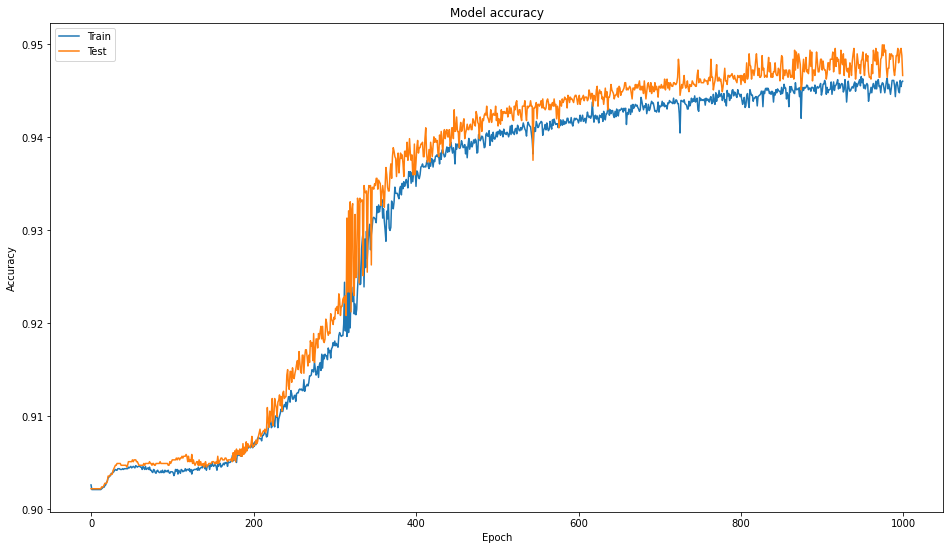

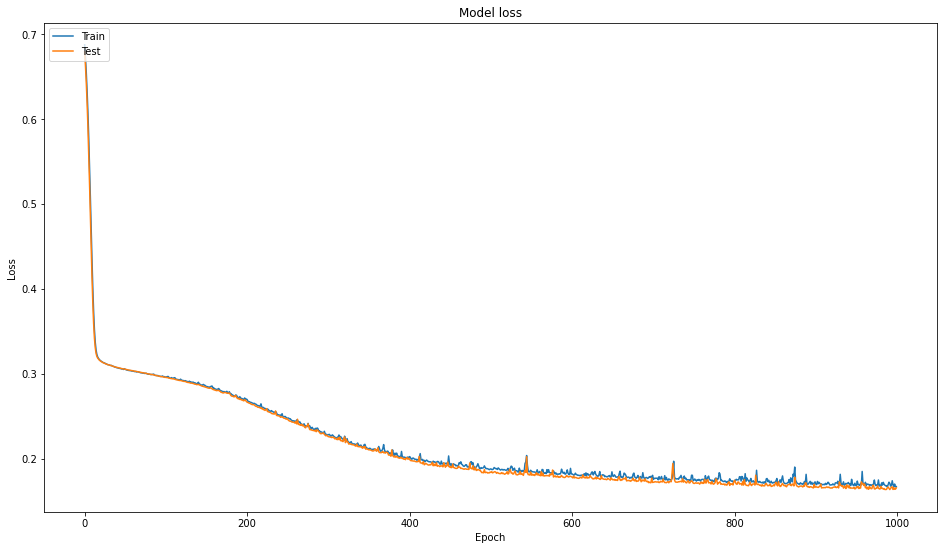

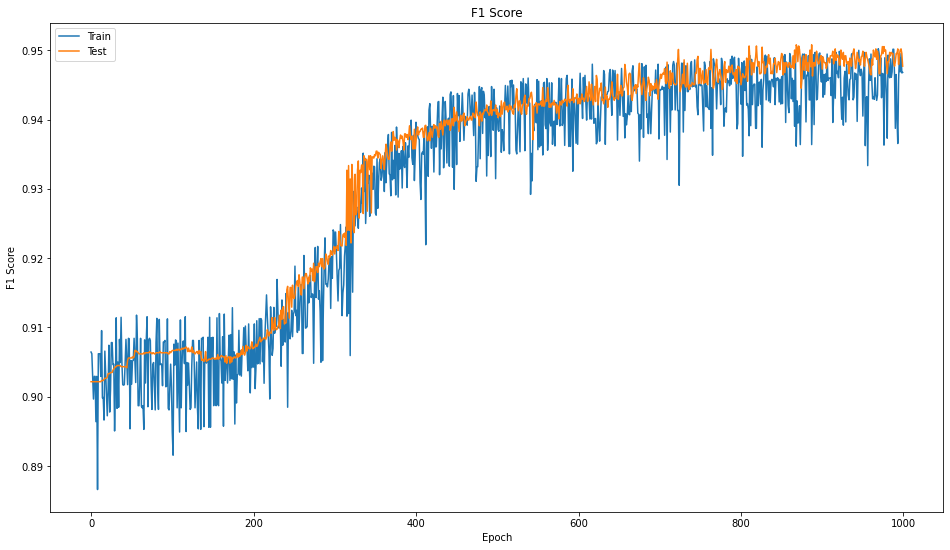

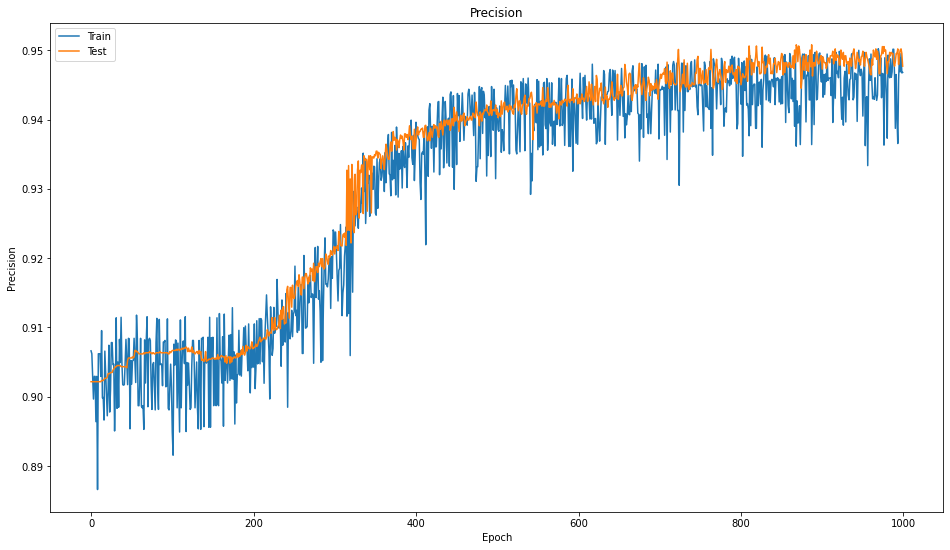

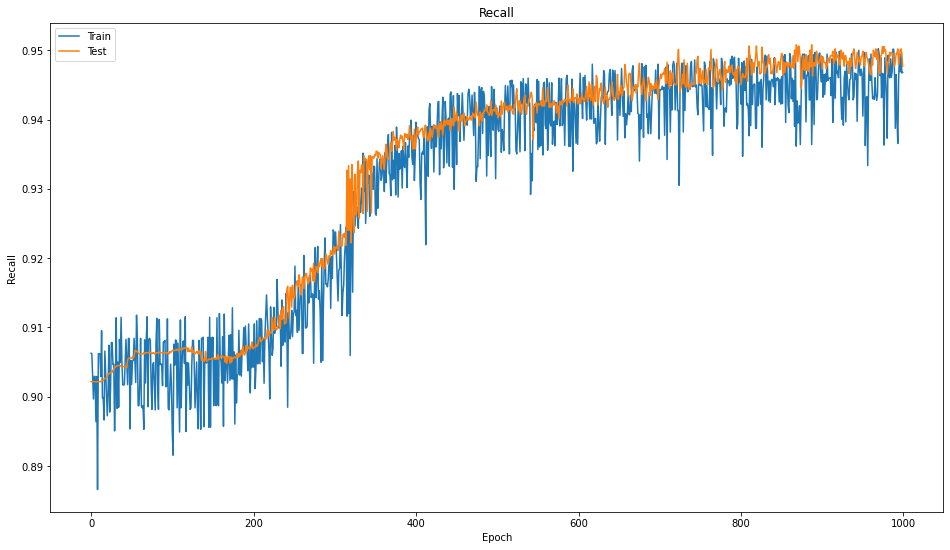

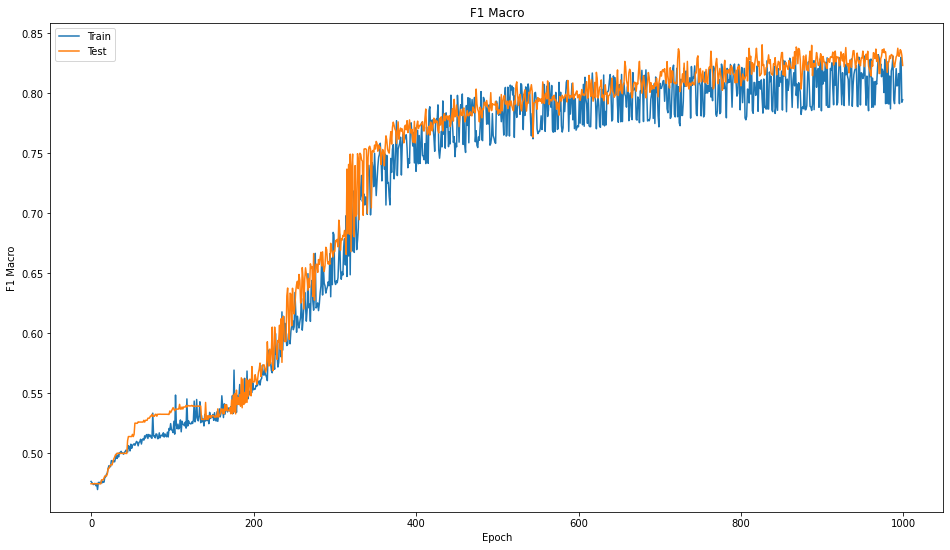

In [0]:
plt.rcParams["figure.figsize"] = [16,9]

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('F1 Macro')
plt.ylabel('F1 Macro')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   

pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))

Accuracy on training data: 0.9388671517372131% 
 Error on training data: 0.061132848262786865
Accuracy on test data: 0.9406171441078186% 
 Error on test data: 0.059382855892181396


In [0]:
pred_test

array([[0.18095325, 0.81904674],
       [0.28575468, 0.71424526],
       [0.19016874, 0.80983126],
       ...,
       [0.2794687 , 0.72053134],
       [0.17790452, 0.82209545],
       [0.1783575 , 0.82164246]], dtype=float32)

In [0]:

test_path =os.path.abspath(os.path.join(os.path.dirname("__file__"), '..', '/content/drive/My Drive/datasets/test.csv'))
test_set = pd.read_csv(test_path, index_col="tripid")


In [0]:
test_set

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
213284604,10.5,924,42,2.44860,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
213286352,10.5,4249,20,0.00000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
213293973,10.5,1552,255,2.65880,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
213294622,10.5,462,16,0.00000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
213298687,10.5,814,392,12.36920,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47
...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723,429,24.83332,3,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48
222857785,10.5,1378,80,0.00000,125,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85
222858416,10.5,418,56,3.28440,93,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79


In [0]:
test_set[training_columns].max()

In [0]:
test_set[training_columns] = test_set[training_columns]/o_training_df[training_columns].max()

In [0]:
test_features = test_set[training_columns]

In [0]:
predicted_labels = model.predict(test_features.values)

In [0]:
predicted_labels

array([[0.20341064, 0.7965894 ],
       [0.70172703, 0.298273  ],
       [0.21694893, 0.78305113],
       ...,
       [0.1760549 , 0.8239451 ],
       [0.1926145 , 0.8073855 ],
       [0.20655984, 0.79344016]], dtype=float32)

In [0]:
predicted_classes = predicted_labels.argmax(axis=-1)

In [0]:
predicted_classes

array([1, 0, 1, ..., 1, 1, 1])

In [0]:
sub_path =os.path.abspath(os.path.join(os.path.dirname("__file__"), '..', '/content/drive/My Drive/datasets/sample_submission.csv'))
submission_set = pd.read_csv(sub_path)

In [0]:
submission_set['prediction'] = predicted_classes

In [0]:
import glob

filename = '/content/drive/My Drive/datasets/k/k_{%i}.csv'
dirname = '/content/drive/My Drive/datasets/k/'
fileversion = 1

if not os.path.exists(dirname):
    os.makedirs(dirname)
while glob.glob(filename.replace('{%i}',str(fileversion))) :
    fileversion+=1
submission_set.to_csv(filename.replace('{%i}',str(fileversion)), index=True)
print("Completed!")



Completed!


In [0]:
submission_set['prediction'].value_counts()

1    8341
0     235
Name: prediction, dtype: int64